# Feature Selection

### Load librarires

In [91]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns

In [92]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.compose import ColumnTransformer
from imblearn.over_sampling import SMOTE

### Load data

In [93]:
path = os.getcwd()
path = path.replace('modeling', 'resources')
files = os.listdir(path)
for file in files:
    if len(file.split('.csv'))>1:
        csv_path = os.path.join(path, file)
data = pd.read_csv(csv_path)

In [94]:
data.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


#### Data Preprocessing

#### Data Cleaning

In [95]:
data['SeniorCitizen']=data['SeniorCitizen'].map({0:'No', 1:'Yes'})
data['TotalCharges']=pd.to_numeric(data.TotalCharges, errors='coerce')
data.drop(data[data.TotalCharges.isna()].index, axis=0, inplace=True)
data.drop('customerID', axis=1, inplace=True)
data.reset_index()

,index,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,0,Female,No,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,1,Male,No,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50,No
2,2,Male,No,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,3,Male,No,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,4,Female,No,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7027,7038,Male,No,Yes,Yes,24,Yes,Yes,DSL,Yes,...,Yes,Yes,Yes,Yes,One year,Yes,Mailed check,84.80,1990.50,No
7028,7039,Female,No,Yes,Yes,72,Yes,Yes,Fiber optic,No,...,Yes,No,Yes,Yes,One year,Yes,Credit card (automatic),103.20,7362.90,No
7029,7040,Female,No,Yes,Yes,11,No,No phone service,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.60,346.45,No
7030,7041,Male,Yes,Yes,No,4,Yes,Yes,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Mailed check,74.40,306.60,Yes


#### Feature Engineering

In [96]:
X = data.drop(['Churn', 'PhoneService'], axis=1)
y = data['Churn'].replace({"Yes":1, "No":0})

internet_addon_services = X.columns[(X == 'No internet service').any()].to_list()
for col in internet_addon_services:
    X[col] = X[col].replace({'No internet service':'No'})

In [97]:
cat_columns = X.select_dtypes(include='object').columns.to_list()
num_columns = X.select_dtypes(include='number').columns.to_list()

cat_columns1 = X.columns[(X == 'No').any()].to_list() #All these features have a 'No' value which we can target and make 0
cat_columns2 = list(set(X.select_dtypes(include='object').columns)-set(cat_columns1))  # We can drop the first column for these features

In [98]:
# Train - Validation - Test Split
X_train_temp, X_test, y_train_temp, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
X_train, X_val, y_train, y_val = train_test_split(X_train_temp, y_train_temp, test_size=0.25, random_state=1)

In [99]:
drop_no = ['No'] * len(cat_columns1)

transformer = [('OH1', OneHotEncoder(sparse_output=False, drop=drop_no), cat_columns1), # One-Hot Encode and drop 'No' value features 
                ('OH2', OneHotEncoder(sparse_output=False, drop='first'), cat_columns2), # One-Hot Encode and drop first column
                ('scaler', MinMaxScaler(), num_columns), # Scale Numerical columns to lie between 0 and 1
                ]

preprocessor = ColumnTransformer(transformer)

In [100]:
# Transform categorical features
X_train_ppd = preprocessor.fit_transform(X_train)
X_val_ppd = preprocessor.transform(X_val)
X_test_ppd = preprocessor.transform(X_test)

feature_names = []
for name, trans, column in preprocessor.transformers_:
    if hasattr(trans, 'get_feature_names_out'):
        feature_names.extend(trans.get_feature_names_out(column))
    else:
        feature_names.extend(column)

X_train_ppd = pd.DataFrame(X_train_ppd, columns=feature_names)
X_val_ppd = pd.DataFrame(X_val_ppd, columns=feature_names)
X_test_ppd = pd.DataFrame(X_test_ppd, columns=feature_names)

In [101]:
# Oversampling
smote = SMOTE(k_neighbors=7, sampling_strategy=0.45, random_state=1)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_ppd, y_train)

In [102]:
columns = X_train_resampled.columns.to_list()
columns

['SeniorCitizen_Yes',
 'Partner_Yes',
 'Dependents_Yes',
 'MultipleLines_No phone service',
 'MultipleLines_Yes',
 'InternetService_DSL',
 'InternetService_Fiber optic',
 'OnlineSecurity_Yes',
 'OnlineBackup_Yes',
 'DeviceProtection_Yes',
 'TechSupport_Yes',
 'StreamingTV_Yes',
 'StreamingMovies_Yes',
 'PaperlessBilling_Yes',
 'PaymentMethod_Credit card (automatic)',
 'PaymentMethod_Electronic check',
 'PaymentMethod_Mailed check',
 'gender_Male',
 'Contract_One year',
 'Contract_Two year',
 'tenure',
 'MonthlyCharges',
 'TotalCharges']

In [103]:
columns = [col.replace("_Yes", "") for col in columns]
columns = ['gender' if col[:6]=='gender' else col for col in columns]
columns = ['No phone service' if col[-16:]=='No phone service' else col for col in columns]
columns

['SeniorCitizen',
 'Partner',
 'Dependents',
 'No phone service',
 'MultipleLines',
 'InternetService_DSL',
 'InternetService_Fiber optic',
 'OnlineSecurity',
 'OnlineBackup',
 'DeviceProtection',
 'TechSupport',
 'StreamingTV',
 'StreamingMovies',
 'PaperlessBilling',
 'PaymentMethod_Credit card (automatic)',
 'PaymentMethod_Electronic check',
 'PaymentMethod_Mailed check',
 'gender',
 'Contract_One year',
 'Contract_Two year',
 'tenure',
 'MonthlyCharges',
 'TotalCharges']

In [104]:
column_rename = dict(zip(X_train_resampled.columns, columns))
X_train_resampled.rename(columns=column_rename, inplace=True)
X_val_ppd.rename(columns=column_rename, inplace=True)
X_test_ppd.rename(columns=column_rename, inplace=True)

In [105]:
display(X_train_resampled.head(3))
display(X_val_ppd.head(3))
display(X_test_ppd.head(3))

,SeniorCitizen,Partner,Dependents,No phone service,MultipleLines,InternetService_DSL,InternetService_Fiber optic,OnlineSecurity,OnlineBackup,DeviceProtection,...,PaperlessBilling,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,gender,Contract_One year,Contract_Two year,tenure,MonthlyCharges,TotalCharges
0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.239437,0.017491,0.039076
1,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.056338,0.017491,0.010175
2,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.000000,0.414293,0.004773


,SeniorCitizen,Partner,Dependents,No phone service,MultipleLines,InternetService_DSL,InternetService_Fiber optic,OnlineSecurity,OnlineBackup,DeviceProtection,...,PaperlessBilling,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,gender,Contract_One year,Contract_Two year,tenure,MonthlyCharges,TotalCharges
0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.507042,0.007996,0.090870
1,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.647887,0.763118,0.518362
2,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.746479,0.910045,0.703909


,SeniorCitizen,Partner,Dependents,No phone service,MultipleLines,InternetService_DSL,InternetService_Fiber optic,OnlineSecurity,OnlineBackup,DeviceProtection,...,PaperlessBilling,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,gender,Contract_One year,Contract_Two year,tenure,MonthlyCharges,TotalCharges
0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1.000000,0.060470,0.212657
1,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.211268,0.666167,0.156732
2,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.873239,0.787106,0.720411


### Model Training

#### Features

In [106]:
X.columns

Index(['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'tenure',
       'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup',
       'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies',
       'Contract', 'PaperlessBilling', 'PaymentMethod', 'MonthlyCharges',
       'TotalCharges'],
      dtype='object')

#### Model fitting

In [107]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression(C= 1, max_iter=25, penalty='l1', solver='liblinear', random_state=1)

model.fit(X_train_resampled, y_train_resampled)

LogisticRegression(C=1, max_iter=25, penalty='l1', random_state=1,
                   solver='liblinear')

#### Evaluation metrics

In [108]:
from sklearn.metrics import accuracy_score, balanced_accuracy_score, roc_auc_score, f1_score, classification_report, confusion_matrix, roc_curve, auc

In [109]:
# ROC AUC Plot
def roc_auc_plot(y_test, y_proba):


    plt.figure(figsize=(4, 4))

    fpr, tpr, _ = roc_curve(y_test, y_proba)
    roc_auc = auc(fpr,tpr)

    plt.plot(fpr, tpr, lw=2, label=f'AUC = {roc_auc:.4f}')
        
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"Receiver Operating Charactristics")
    plt.legend(loc="lower right")

    #Diagonal Line
    plt.plot([0,1], [0,1], color = 'navy', lw=2, linestyle='--')

    plt.show()

Accuracy: 0.81, Balanced Accuracy: 0.75, F1 Score: 0.75


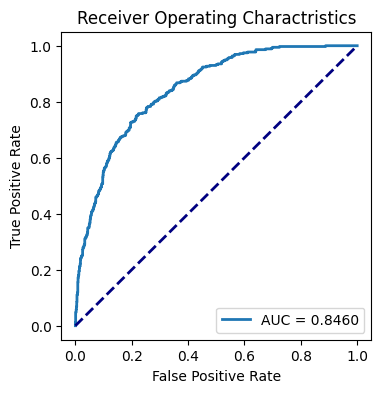

              precision    recall  f1-score   support

           0       0.87      0.87      0.87      1052
           1       0.62      0.62      0.62       355

    accuracy                           0.81      1407
   macro avg       0.75      0.75      0.75      1407
weighted avg       0.81      0.81      0.81      1407

[[919 133]
 [135 220]]


In [110]:
y_pred = model.predict(X_val_ppd)

# Calculate Metrics
acc = accuracy_score(y_val, y_pred)
bal_acc = balanced_accuracy_score(y_val, y_pred)
f1 = f1_score(y_val, y_pred, average='macro')

# Printing metrics
print(f"Accuracy: {acc:.2f}, Balanced Accuracy: {bal_acc:.2f}, F1 Score: {f1:.2f}")

# Check if the model has the predict_proba method
if hasattr(model, 'predict_proba'):
    y_proba = model.predict_proba(X_val_ppd)[:, 1]
# Otherwise, use decision_function for LinearSVC
else:
    y_proba = model.decision_function(X_val_ppd)

roc_auc_plot(y_val, y_proba)

print(classification_report(y_val, y_pred))
print(confusion_matrix(y_val, y_pred))

### Feature Selection

#### Permutation importance - ELI5

In [111]:
import eli5
from eli5.sklearn import PermutationImportance

feature_names  = X_val_ppd.columns.to_list()
perm = PermutationImportance(model, random_state=1).fit(X_val_ppd, y_val)
eli5.show_weights(perm, feature_names = feature_names, top=len(X_val_ppd.columns))

Weight,Feature
0.1016 ± 0.0090,tenure
0.0775 ± 0.0129,InternetService_Fiber optic
0.0279 ± 0.0120,TotalCharges
0.0151 ± 0.0097,Contract_Two year
0.0101 ± 0.0039,MultipleLines
0.0098 ± 0.0056,PaperlessBilling
0.0084 ± 0.0035,PaymentMethod_Electronic check
0.0082 ± 0.0031,StreamingMovies
0.0075 ± 0.0063,Contract_One year
0.0063 ± 0.0063,InternetService_DSL


#### Prmutation Importance and testing - Sci-kit learn

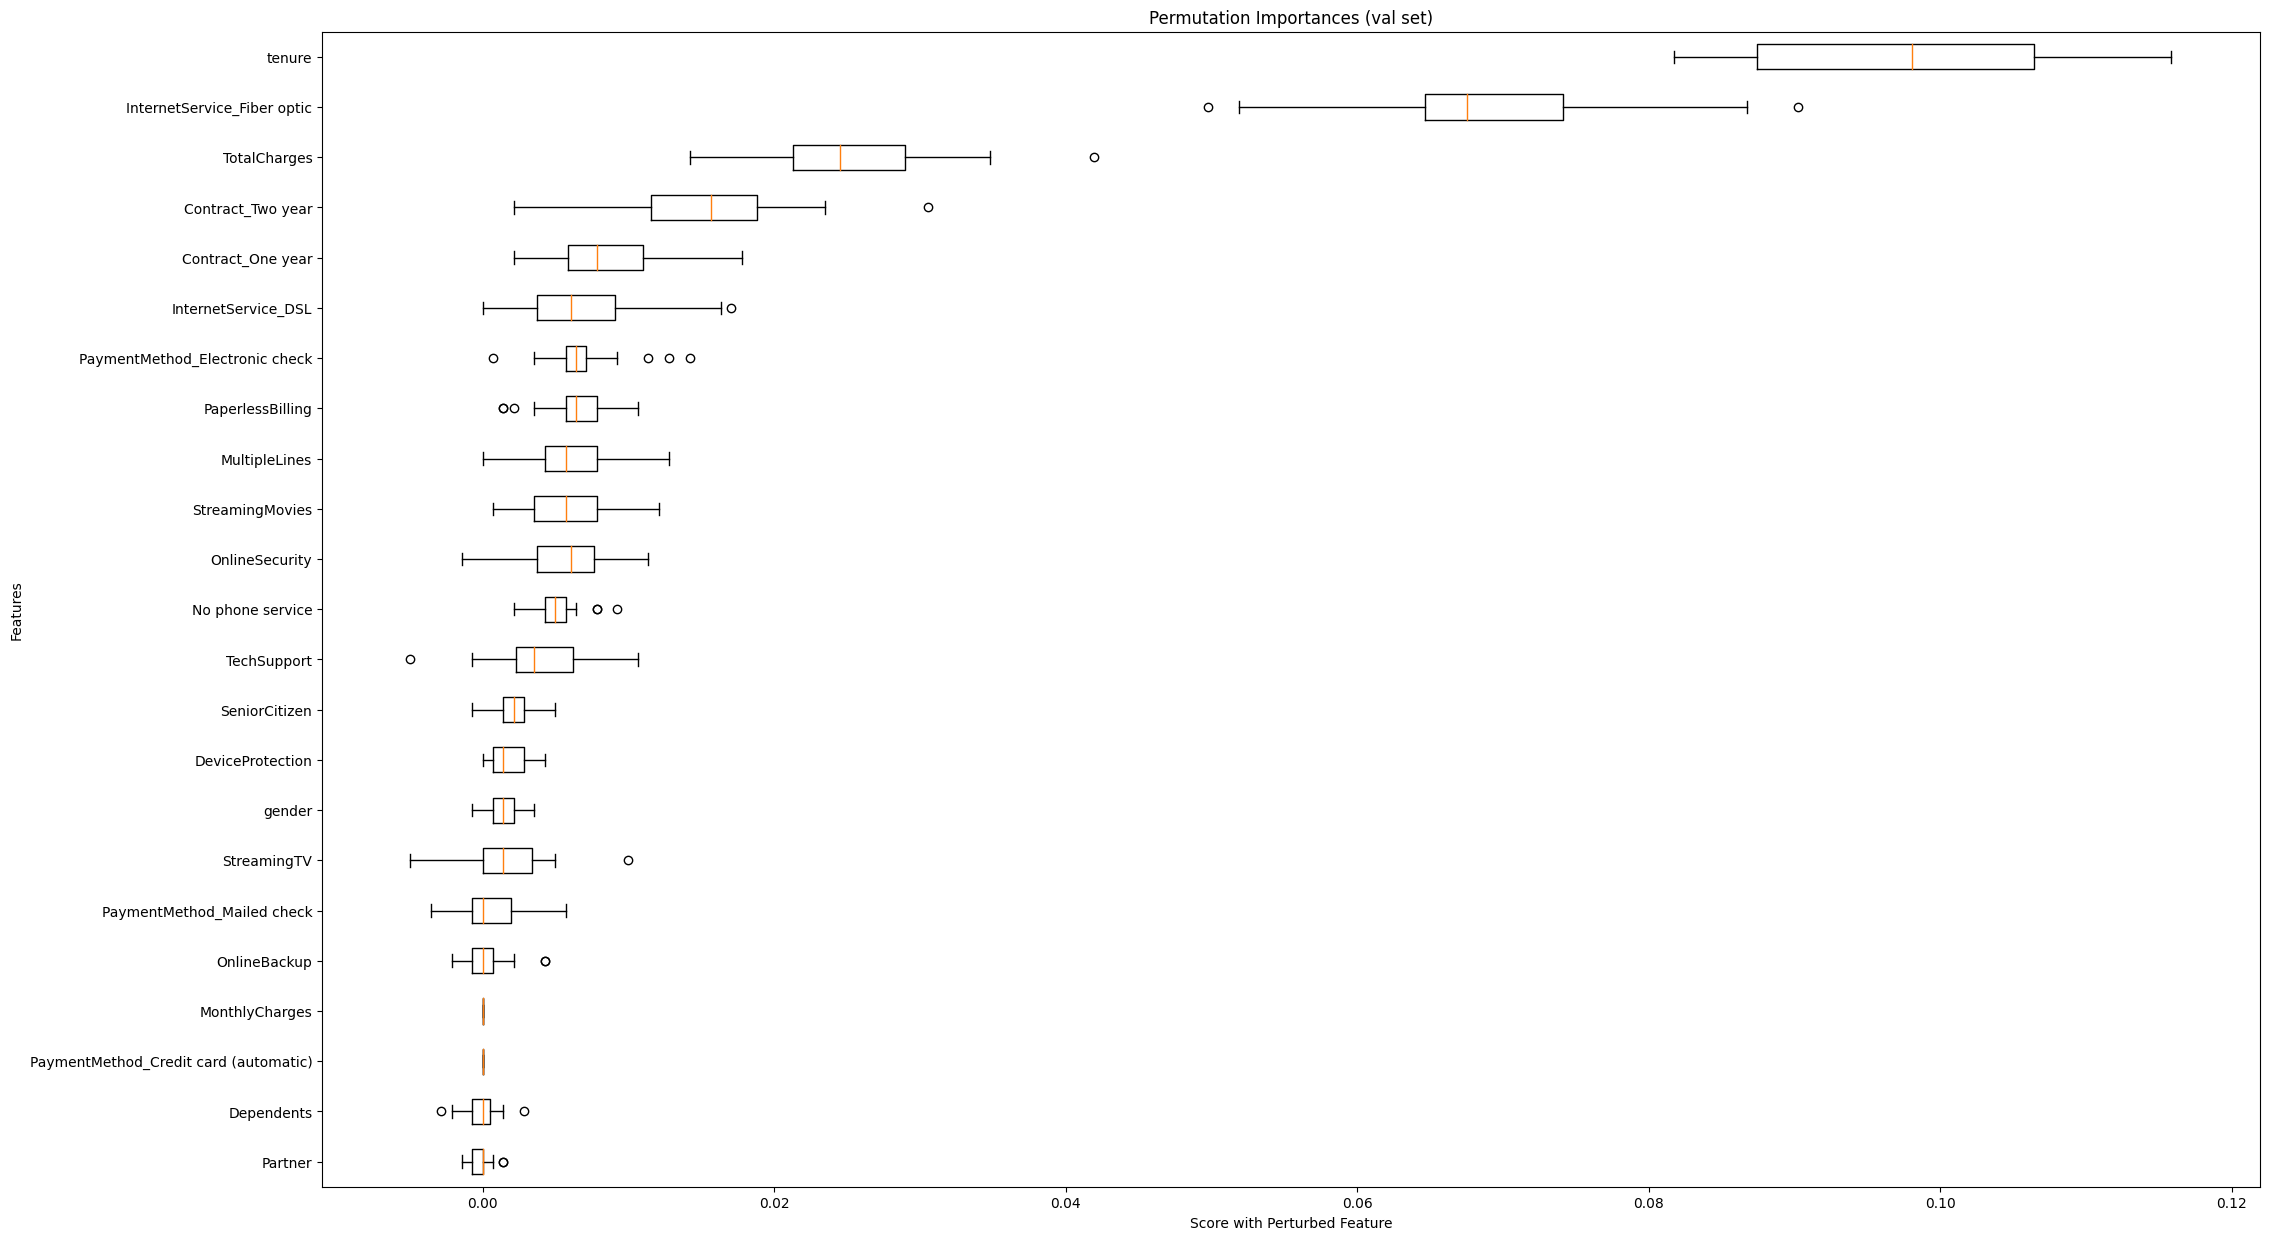

Removed Features: 


['Dependents',
 'MonthlyCharges',
 'Partner',
 'PaymentMethod_Credit card (automatic)']

              precision    recall  f1-score   support

           0       0.87      0.87      0.87      1052
           1       0.63      0.63      0.63       355

    accuracy                           0.81      1407
   macro avg       0.75      0.75      0.75      1407
weighted avg       0.81      0.81      0.81      1407

[[920 132]
 [133 222]]


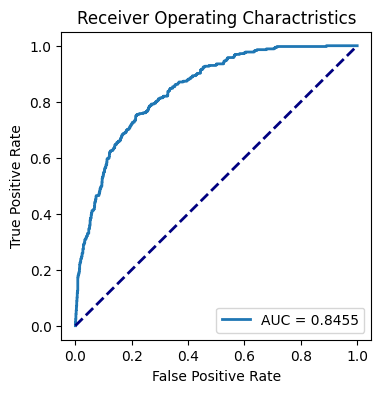

In [112]:
from sklearn.inspection import permutation_importance

result = permutation_importance(model, X_val_ppd, y_val, n_repeats=30, random_state=1)

sorted_idx = result.importances_mean.argsort()

plt.figure(figsize=(25, 15))
plt.boxplot(result.importances[sorted_idx].T, vert=False, labels=np.array(feature_names)[sorted_idx])
plt.title("Permutation Importances (val set)")
plt.xlabel("Score with Perturbed Feature")
plt.ylabel("Features")
plt.show()

# Selecting features with importance above a threshold
threshold = 0.0001  # You can choose the threshold based on the plot or other criteria
important_features = np.array(feature_names)[result.importances_mean > threshold]

print("Removed Features: ")
display(list(set(feature_names)-set(important_features)))
# You can then train your model using only the selected important features
X_train_imp = X_train_resampled[important_features]
X_val_imp = X_val_ppd[important_features]

model2 = LogisticRegression(C= 1, max_iter=25, penalty='l1', solver='liblinear', random_state=1)
# Fit the model with the important features
model2.fit(X_train_imp, y_train_resampled)

# val the model with the important features
y_pred_imp = model2.predict(X_val_imp)
y_proba_imp = model2.predict_proba(X_val_imp)[:,1]

# Evaluate the model
print(classification_report(y_val, y_pred_imp))
print(confusion_matrix(y_val, y_pred_imp))
roc_auc_plot(y_val, y_proba_imp)

#### Manual Testing

In [114]:
X_train_resampled.columns

Index(['SeniorCitizen', 'Partner', 'Dependents', 'No phone service',
       'MultipleLines', 'InternetService_DSL', 'InternetService_Fiber optic',
       'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport',
       'StreamingTV', 'StreamingMovies', 'PaperlessBilling',
       'PaymentMethod_Credit card (automatic)',
       'PaymentMethod_Electronic check', 'PaymentMethod_Mailed check',
       'gender', 'Contract_One year', 'Contract_Two year', 'tenure',
       'MonthlyCharges', 'TotalCharges'],
      dtype='object')

##### Validation set

Accuracy: 0.81, Balanced Accuracy: 0.75, F1 Score: 0.75


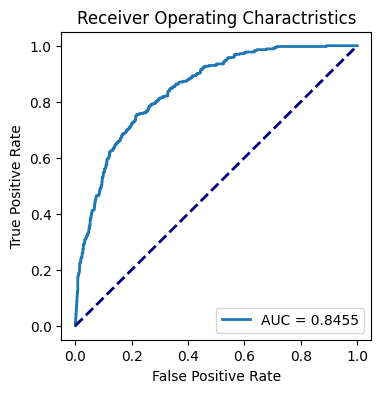

              precision    recall  f1-score   support

           0       0.87      0.87      0.87      1052
           1       0.63      0.63      0.63       355

    accuracy                           0.81      1407
   macro avg       0.75      0.75      0.75      1407
weighted avg       0.81      0.81      0.81      1407

[[920 132]
 [133 222]]


In [127]:
features_to_drop = ['Dependents',
 'MonthlyCharges',
 'Partner'
 ]

X_train_selected = X_train_resampled.drop(features_to_drop, axis=1)
X_val_selected = X_val_ppd.drop(features_to_drop, axis=1)
X_test_selected = X_test_ppd.drop(features_to_drop, axis=1)

model.fit(X_train_selected, y_train_resampled)

y_pred = model.predict(X_val_selected)

# Calculate Metrics
acc = accuracy_score(y_val, y_pred)
bal_acc = balanced_accuracy_score(y_val, y_pred)
f1 = f1_score(y_val, y_pred, average='macro')

# Printing metrics
print(f"Accuracy: {acc:.2f}, Balanced Accuracy: {bal_acc:.2f}, F1 Score: {f1:.2f}")

# Check if the model has the predict_proba method
if hasattr(model, 'predict_proba'):
    y_proba = model.predict_proba(X_val_selected)[:, 1]
# Otherwise, use decision_function for LinearSVC
else:
    y_proba = model.decision_function(X_val_selected)

roc_auc_plot(y_val, y_proba)

print(classification_report(y_val, y_pred))
print(confusion_matrix(y_val, y_pred))

##### Test Set

Accuracy: 0.80, Balanced Accuracy: 0.74, F1 Score: 0.74


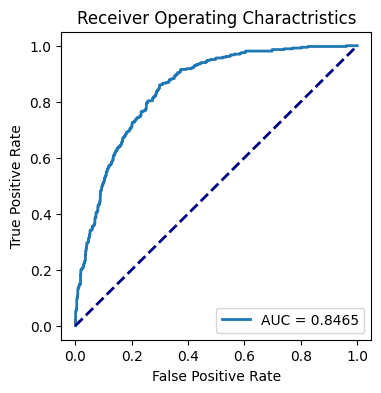

              precision    recall  f1-score   support

           0       0.86      0.86      0.86      1041
           1       0.61      0.61      0.61       366

    accuracy                           0.80      1407
   macro avg       0.74      0.74      0.74      1407
weighted avg       0.80      0.80      0.80      1407

[[899 142]
 [143 223]]


In [128]:
y_pred = model.predict(X_test_selected)

# Calculate Metrics
acc = accuracy_score(y_test, y_pred)
bal_acc = balanced_accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='macro')

# Printing metrics
print(f"Accuracy: {acc:.2f}, Balanced Accuracy: {bal_acc:.2f}, F1 Score: {f1:.2f}")

# Check if the model has the predict_proba method
if hasattr(model, 'predict_proba'):
    y_proba = model.predict_proba(X_test_selected)[:, 1]
# Otherwise, use decision_function for LinearSVC
else:
    y_proba = model.decision_function(X_test_selected)

roc_auc_plot(y_test, y_proba)

print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

### Feature Selection Summary

We can see that `MonthlyCharges` does not make much difference whetehr its i present or absent. As seen from feature egineerin, it is not the monthly charge that causes a person to churn. The customers churn when they do not receive certain services, and they do not opt for those services because it costs more.

Parthners and Dependents are two features that resulted in a minor improvment in models performance when removed. This improvment is negligible and did not result in a difference for the test set. We shall therefore retain all engineered features.

We are now ready to serialize the model and use it in production